In [93]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../analysisTools/")
import plotTools as ptools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
prefix = './coffea/skimmed/'
suffix = '_SR_v3_skimmed_noDisplacementCut'

# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [95]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10', 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-100', 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-1', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-100', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-10

In [96]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10', 'cut11', 'cut12', 'cut13', 'cut14']


In [97]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                         mchi  dmchi   ctau    m1    m2  \
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10      5.50    1.0   10.0   5.0   6.0   
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100     5.50    1.0  100.0   5.0   6.0   
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1       5.50    1.0    1.0   5.0   6.0   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100    5.25    0.5  100.0   5.0   5.5   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10     5.25    0.5   10.0   5.0   5.5   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1      5.25    0.5    1.0   5.0   5.5   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100  55.00   10.0  100.0  50.0  60.0   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10   55.00   10.0   10.0  50.0  60.0   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1    55.00   10.0    1.0  50.0  60.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10    52.50    5.0   10.0  50.0  55.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100   52.50    5.0  100.0  50.0  55.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1     52.50    5.0    1.0  50.0  55.0   
sig_2018_Mchi-44p0_dMchi-

In [98]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

In [99]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

In [100]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

In [121]:
sig_histo[hname][{"samp":'sig_2018_Mchi-5p5_dMchi-1p0_ctau-10',"cut":'cut14'}]

Hist(Regular(100, 0, 100, name='vxy_signif', label='Vertex $v_{xy}$ Significance'), storage=Weight()) # Sum: WeightedSum(value=1.80475, variance=0.120635) (WeightedSum(value=2.40674, variance=0.160901) with flow)

In [152]:
# Access all the sub-samples of the sample (or process) 'DY' at certain cut
s_over_b = {}
s = {}


cut = 'cut14'

hname = 'sel_vtx_vxySignif'
rebin = 2j

for point in sig_samples:
    #point = 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-10'
    #print(point)
    # sig
    sig_hist = sig_histo[hname][{"samp":point,"cut":cut}][0:hist.overflow][::rebin]
    
    bins = sig_hist.axes[0].edges[1:]
    
    s[point] = []
    for idx, bin_edge in enumerate(bins):
        if idx == 0:
            continue
        else:
            integral = sig_hist[0:idx].sum().value
            s[point].append(sig_hist.sum(flow=True).value - integral) # apply cut of: var > cutvalue
    
    # bkg
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
        
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))
    
    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    bkgs = [bkg_stack[process] for process in bkg_stack.keys()]
    bkg_total = sum(bkgs)
    
    b = []
    for idx, bin_edge in enumerate(bins):
        if idx == 0:
            continue
        else:
            integral = bkg_total[0:idx].sum().value
            b.append(bkg_total.sum(flow=True).value - integral) # apply cut of: var > cutvalue
    
    # s/sqrt(b)
    s[point] = np.array(s[point])
    b = np.array(b)
    
    s_over_b[point] = list(s[point]/np.sqrt(b))
    s_over_b

In [153]:
sig_hist

Hist(Regular(50, 0, 100, name='vxy_signif', label='Vertex $v_{xy}$ Significance'), storage=Weight()) # Sum: WeightedSum(value=869.487, variance=4638.13) (WeightedSum(value=928.161, variance=4951.11) with flow)

In [154]:
bkg_total

Hist(Regular(50, 0, 100, name='vxy_signif', label='Vertex $v_{xy}$ Significance'), storage=Weight()) # Sum: WeightedSum(value=362.966, variance=20689.1) (WeightedSum(value=365.936, variance=20689.9) with flow)

In [155]:
s[point]

array([778.74196434, 650.71538639, 560.05430174, 496.01268816,
       453.36935616, 400.09072876, 368.14541674, 357.46848392,
       352.12429094, 336.13133812, 320.11785078, 298.80788565,
       282.78309727, 272.114223  , 245.45866489, 240.13702774,
       218.82241583, 208.16194582, 208.16194582, 197.51321697,
       197.51321697, 165.47450733, 144.10906124, 138.75387192,
       122.75462818, 122.75462818, 122.75462818, 117.41530895,
       106.72610235, 106.72610235, 101.39684868,  96.08784723,
        85.42954254,  80.10874033,  80.10874033,  80.10874033,
        80.10874033,  80.10874033,  80.10874033,  74.75368261,
        69.40654469,  69.40654469,  69.40654469,  64.02497578,
        64.02497578,  64.02497578,  64.02497578,  64.02497578,
        64.02497578])

In [156]:
b

array([156.49303046, 113.66864113,  80.00022078,  58.0425819 ,
        45.49617006,  35.47384388,  30.23867792,  26.97455788,
        22.72476234,  20.36559617,  16.34188538,  13.46060844,
        12.08237787,  10.54679254,  10.23139463,   9.86194165,
         8.26982356,   7.02226312,   6.11970787,   5.77515023,
         5.39350001,   5.39350001,   5.35012087,   5.00556323,
         5.00556323,   4.97684976,   4.97684976,   4.97684976,
         4.97684976,   4.97684976,   4.79212327,   4.60739677,
         4.60739677,   4.42267028,   4.07811264,   3.89338615,
         3.89338615,   3.70865966,   3.70865966,   3.70865966,
         3.70865966,   3.52393316,   3.52393316,   3.52393316,
         3.52393316,   3.52393316,   3.17937552,   3.15505153,
         2.97032503])

In [157]:
s_over_b

{'sig_2018_Mchi-5p5_dMchi-1p0_ctau-10': [0.1710229288619696,
  0.19440645213548002,
  0.20922077159634142,
  0.22815664273864933,
  0.24778425282919556,
  0.280612489540025,
  0.3039343055479828,
  0.32179845475577995,
  0.3366069518325786,
  0.3407954762720859,
  0.3308385857939263,
  0.36453135525004476,
  0.3847609858417568,
  0.39125833484710143,
  0.39724312167736103,
  0.38334424089833774,
  0.3952833612866342,
  0.4289612940281835,
  0.45950613072231805,
  0.4452157349196449,
  0.46069850824715025,
  0.46069850824715025,
  0.4048111241797163,
  0.41851185011534386,
  0.3887159330254932,
  0.3898356504032144,
  0.35979930792074455,
  0.35979930792074455,
  0.35979930792074455,
  0.35979930792074455,
  0.36666849708512983,
  0.37394676615318406,
  0.3427427735638283,
  0.3498274079593556,
  0.364306152058518,
  0.3728484775532529,
  0.3389852521918239,
  0.34732500770722174,
  0.34732500770722174,
  0.31259478027137333,
  0.31259478027137333,
  0.3206833268049708,
  0.320683326804

In [158]:
'''
print(s_over_b)

mask_finite = np.isfinite(s_over_b)

s_over_b = s_over_b[mask_finite]
bin_range = bins[np.where(mask_finite)]
'''

'\nprint(s_over_b)\n\nmask_finite = np.isfinite(s_over_b)\n\ns_over_b = s_over_b[mask_finite]\nbin_range = bins[np.where(mask_finite)]\n'

Text(0.5, 0, 'Cut value of vxy significance')

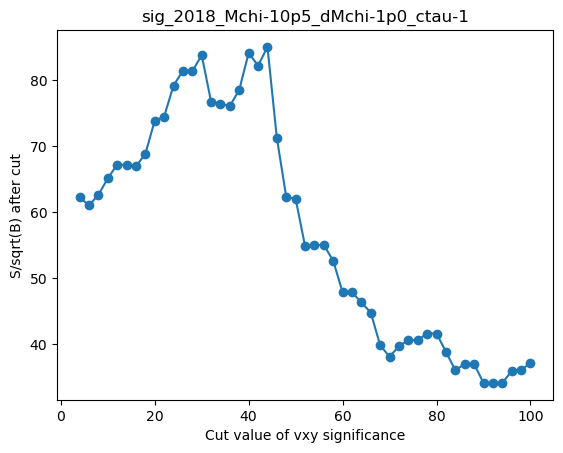

In [159]:
plt.plot(bins[1:], s_over_b[point], '-o')
plt.title(point)
plt.ylabel('S/sqrt(B) after cut')
plt.xlabel('Cut value of vxy significance')

In [240]:
sig_samples

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10',
 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-100',
 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-1',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-100',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-10',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-1',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1',
 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100',
 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-10',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-100',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1',
 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100',
 'sig_2018_Mch

In [272]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [248]:
ctau_1_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-1'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-1'],
                                   ])

ctau_1_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-1'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-1'],
                                 ])

In [250]:
ctau_1_arr = np.array([s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1'],
                        s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-1'], 
                        s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-1'], 
                        s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-1'],
                      ])

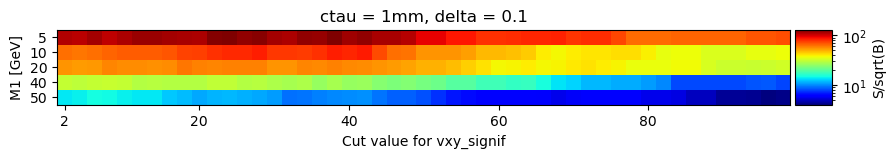

In [273]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_1_delta_0p1_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 1mm, delta = 0.1')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

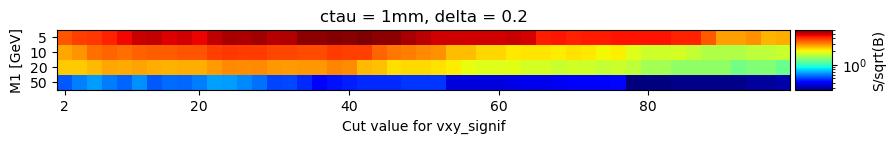

In [274]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_1_delta_0p2_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3], [5,10,20,50])

plt.title('ctau = 1mm, delta = 0.2')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

In [257]:
ctau_10_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-10'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-10'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-10'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-10'],
                                   ])

ctau_10_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-10'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-10'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-10'],
                                 ])

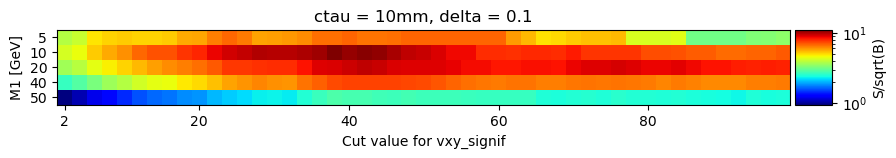

In [275]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_10_delta_0p1_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 10mm, delta = 0.1')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

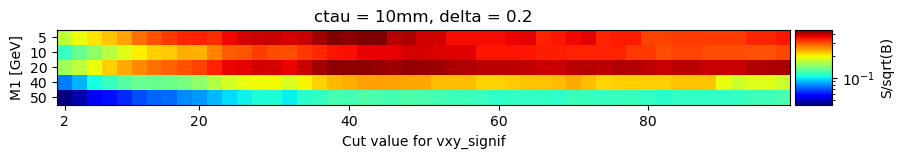

In [276]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_10_delta_0p2_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 10mm, delta = 0.2')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

In [261]:
ctau_100_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-100'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-100'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-100'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-100'],
                                   ])

ctau_100_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-100'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-100'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-100'],
                                 ])

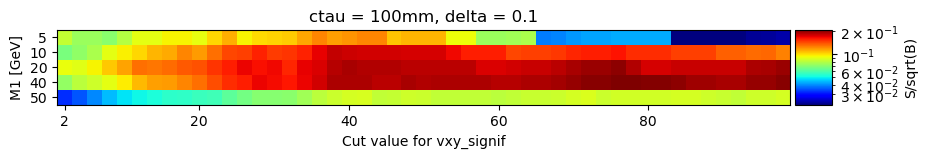

In [277]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_100_delta_0p1_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 100mm, delta = 0.1')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

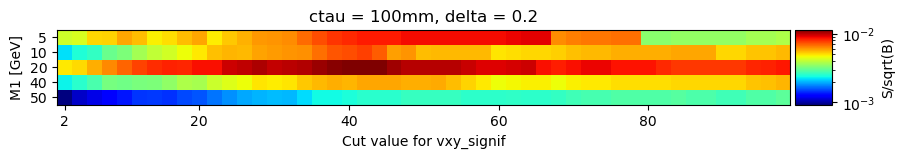

In [278]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_100_delta_0p2_arr
im = ax.imshow(arr, norm=colors.LogNorm(vmin=arr.min(), vmax=arr.max()), cmap='jet')

# label, ticks and title
plt.xlabel('Cut value for vxy_signif')
plt.ylabel('M1 [GeV]')

plt.xticks([0,9,19,29,39], [2,20,40,60,80])
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 100mm, delta = 0.2')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

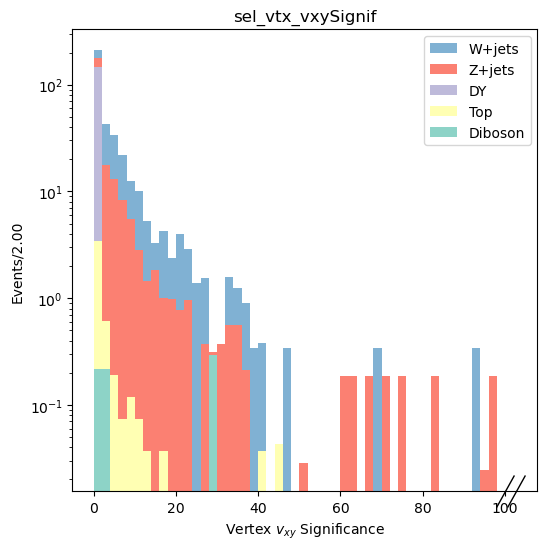

In [148]:
plot_bkg(hname, 'cut14', title=hname, rebin=2j)

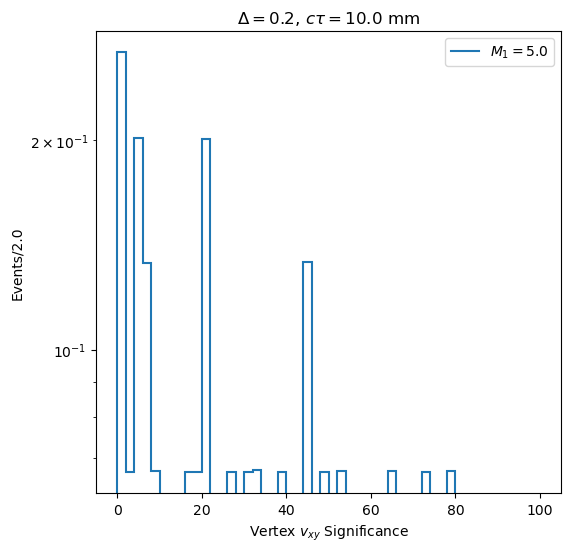

In [149]:
plot_sig(hname, cut='cut14', delta=0.2, m1=5.0, ct=10.0, rebin=2j)

In [306]:
# Access all the sub-samples of the sample (or process) 'DY' at certain cut
s_over_b = {}
s = {}


cut = 'cut14'

hname = 'sel_vtx_minDxy'
rebin = 1j

for point in sig_samples:
    #point = 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-10'
    #print(point)
    # sig
    sig_hist = sig_histo[hname][{"samp":point,"cut":cut}][0:hist.overflow][::rebin]
    
    bins = sig_hist.axes[0].edges[1:]
    
    s[point] = []
    for idx, bin_edge in enumerate(bins):
        if idx == 0:
            continue
        else:
            integral = sig_hist[0:idx].sum().value
            s[point].append(sig_hist.sum(flow=True).value - integral) # apply cut of: var > cutvalue
    
    # bkg
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
        
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))
    
    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    bkgs = [bkg_stack[process] for process in bkg_stack.keys()]
    bkg_total = sum(bkgs)
    
    b = []
    for idx, bin_edge in enumerate(bins):
        if idx == 0:
            continue
        else:
            integral = bkg_total[0:idx].sum().value
            b.append(bkg_total.sum(flow=True).value - integral) # apply cut of: var > cutvalue
    
    # s/sqrt(b)
    s[point] = np.array(s[point])
    b = np.array(b)
    
    s_over_b[point] = list(s[point]/np.sqrt(b))
    s_over_b

/tmp/ipykernel_25933/1979601461.py:52: RuntimeWarning: invalid value encountered in divide
  s_over_b[point] = list(s[point]/np.sqrt(b))
/tmp/ipykernel_25933/1979601461.py:52: RuntimeWarning: divide by zero encountered in divide
  s_over_b[point] = list(s[point]/np.sqrt(b))


In [307]:
sig_hist

Hist(Regular(500, 0, 5, name='dxy', label='Electron Track $d_{xy}$'), storage=Weight()) # Sum: WeightedSum(value=928.161, variance=4951.11)

In [308]:
bkg_total

Hist(Regular(500, 0, 5, name='dxy', label='Electron Track $d_{xy}$'), storage=Weight()) # Sum: WeightedSum(value=365.936, variance=20689.9)

In [309]:
s[point]

array([528.12302113, 341.51156712, 229.52688026, 170.83529091,
       149.45160818, 144.09760141, 112.09016371,  90.7316308 ,
        74.77323484,  69.41517782,  58.76673651,  37.39876842,
        37.39876842,  37.39876842,  26.71177673,  21.35945559,
        16.01989651,  10.68347836,  10.68347836,  10.68347836,
        10.68347836,  10.68347836,  10.68347836,  10.68347836,
        10.68347836,  10.68347836,   5.33334923,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [310]:
bin_range={}
for point in sig_samples:
    mask_finite = np.isfinite(s_over_b[point])
    
    s_over_b[point] = np.array(s_over_b[point])[mask_finite]
    
    bin_range[point] = bins[np.where(mask_finite)]

In [311]:
bin_range

{'sig_2018_Mchi-5p5_dMchi-1p0_ctau-10': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
        0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
        0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
        0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
        0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
        1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
        1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
        1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
        1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,

Text(0.5, 0, 'Cut value of minDxy')

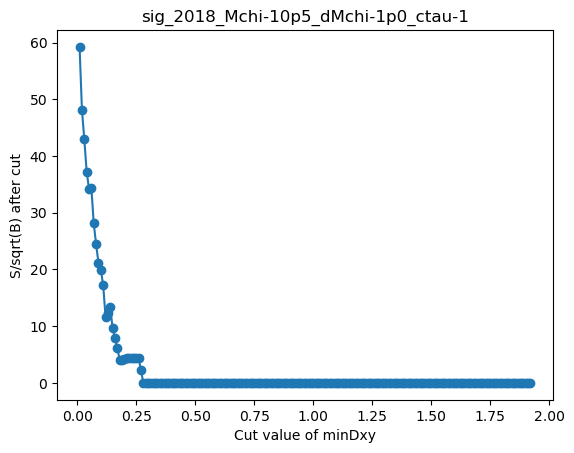

In [312]:
plt.plot(bin_range[point], s_over_b[point], '-o')
plt.title(point)
plt.ylabel('S/sqrt(B) after cut')
plt.xlabel('Cut value of minDxy')

In [313]:
sig_samples

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10',
 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-100',
 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-1',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-100',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-10',
 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-1',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10',
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100',
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1',
 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100',
 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-10',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100',
 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-100',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10',
 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100',
 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1',
 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100',
 'sig_2018_Mch

In [314]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [315]:
ctau_1_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-1'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-1'],
                                   ])

ctau_1_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-1'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-1'],
                                    #s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-1'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-1'],
                                 ])

In [316]:
ctau_1_arr = np.array([s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1'],
                        s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-1'], 
                        s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-1'], 
                        s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-1'],
                        #s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-1'],
                        s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-1'],
                      ])

In [321]:
bin_range[point][0:40]

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ])

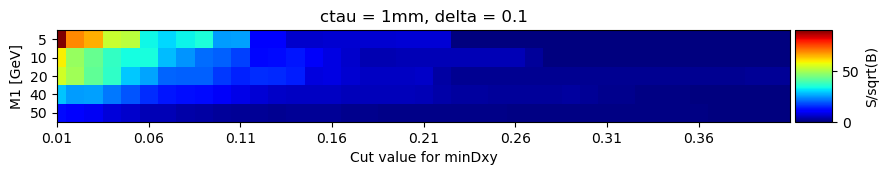

In [326]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_1_delta_0p1_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmax = 40
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmax/5)) ]
new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([0,xbinmax])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 1mm, delta = 0.1')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

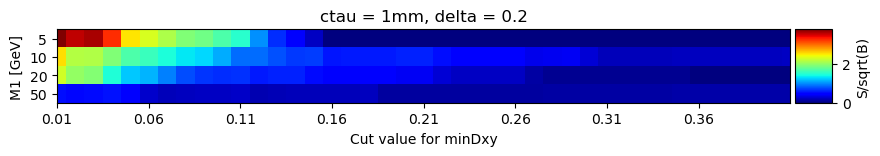

In [328]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_1_delta_0p2_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmax = 40
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmax/5)) ]
new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([0,xbinmax])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3], [5,10,20,50])

plt.title('ctau = 1mm, delta = 0.2')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

In [329]:
ctau_10_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-10'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-10'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-10'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-10'],
                                   ])

ctau_10_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-10'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-10'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-10'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-10'],
                                 ])

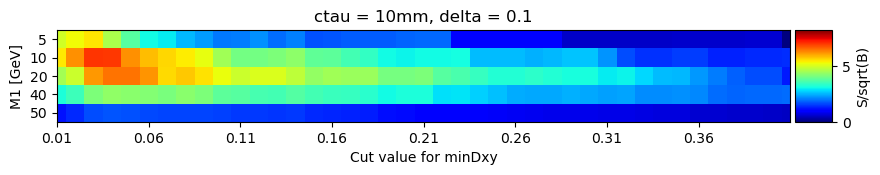

In [330]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_10_delta_0p1_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmax = 40
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmax/5)) ]
new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([0,xbinmax])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 10mm, delta = 0.1')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

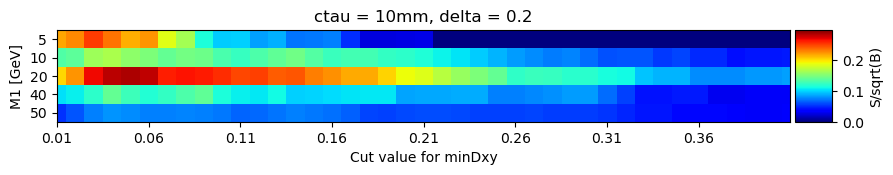

In [331]:
plt.figure(figsize=(10,6))
ax = plt.gca()

arr = ctau_10_delta_0p2_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmax = 40
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmax/5)) ]
new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([0,xbinmax])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 10mm, delta = 0.2')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

In [370]:
ctau_100_delta_0p1_arr = np.array(   [s_over_b['sig_2018_Mchi-5p25_dMchi-0p5_ctau-100'],
                                    s_over_b['sig_2018_Mchi-10p5_dMchi-1p0_ctau-100'], 
                                    s_over_b['sig_2018_Mchi-21p0_dMchi-2p0_ctau-100'],
                                    #s_over_b['sig_2018_Mchi-31p5_dMchi-3p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-42p0_dMchi-4p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-52p5_dMchi-5p0_ctau-100'],
                                   ])

ctau_100_delta_0p2_arr = np.array( [  s_over_b['sig_2018_Mchi-5p5_dMchi-1p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-11p0_dMchi-2p0_ctau-100'], 
                                    s_over_b['sig_2018_Mchi-22p0_dMchi-4p0_ctau-100'],
                                    #s_over_b['sig_2018_Mchi-33p0_dMchi-6p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-44p0_dMchi-8p0_ctau-100'],
                                    s_over_b['sig_2018_Mchi-55p0_dMchi-10p0_ctau-100'],
                                 ])

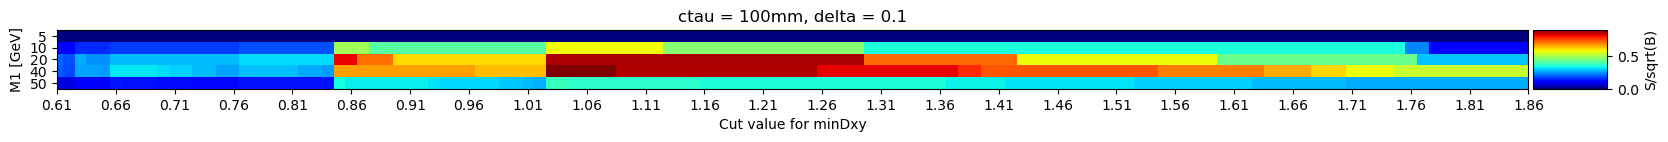

In [375]:
plt.figure(figsize=(20,20))
ax = plt.gca()

arr = ctau_100_delta_0p1_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmin = 60
xbinmax = len(bin_range[point])
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmin/5), int(xbinmax/5)) ]

new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([60,180])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 100mm, delta = 0.1')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

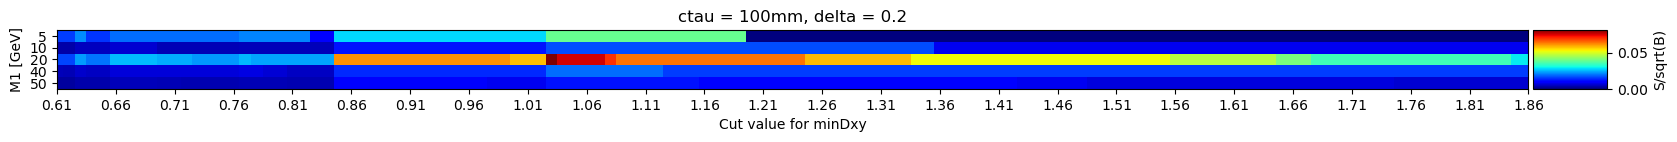

In [372]:
plt.figure(figsize=(20,20))
ax = plt.gca()

arr = ctau_100_delta_0p2_arr
im = ax.imshow(arr, cmap='jet')

# label, ticks and title
xbinmin = 60
xbinmax = len(bin_range[point])
xtick = bin_range[point][0:xbinmax]
default_xticks = [ int(5*i) for i in range(int(xbinmin/5), int(xbinmax/5)) ]

new_xticks = [ '{:.2f}'.format(xtick[i]) for i in default_xticks ]


plt.xlim([60,180])
plt.xlabel('Cut value for minDxy')
plt.ylabel('M1 [GeV]')

plt.xticks(default_xticks, new_xticks)
plt.yticks([0,1,2,3,4], [5,10,20,40,50])

plt.title('ctau = 100mm, delta = 0.2')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax, label='S/sqrt(B)')

In [363]:
bin_range[point][60]

0.61

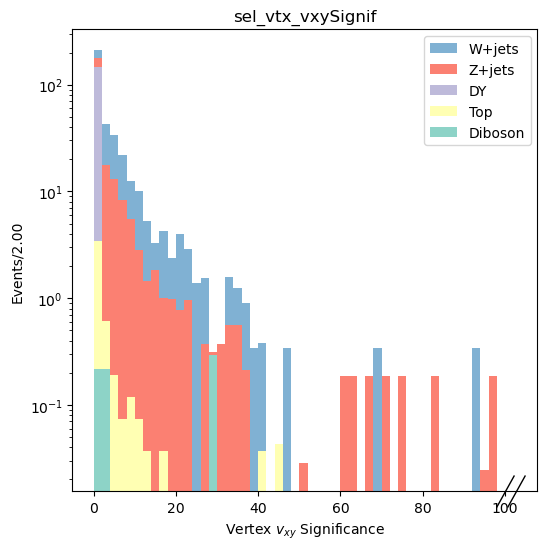

In [148]:
plot_bkg(hname, 'cut14', title=hname, rebin=2j)

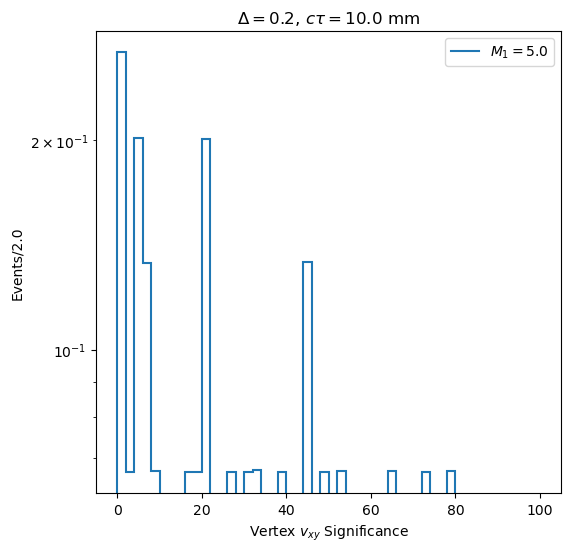

In [149]:
plot_sig(hname, cut='cut14', delta=0.2, m1=5.0, ct=10.0, rebin=2j)